<h2> Imports </h2>

In [30]:
from ngboost import NGBRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from ngboost.distns import Exponential, Normal
from scipy.stats import burr
from ngboost.scores import LogScore, CRPScore
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats.stats import pearsonr, spearmanr
import math
from scipy import stats
# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from matplotlib import pyplot
from scipy.spatial import distance
import warnings
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression
from sklearn.metrics.cluster import normalized_mutual_info_score
warnings.filterwarnings("ignore")

<h2> Helper Methods </h2>

In [2]:
## Generate lags for all input features, re-generate even if some exist so that order will not be shuffled after nan dropping
def generate_lags_for(df, column, lags_count):
        for i in range(lags_count):
            lag_name = column + "-" + str(i + 1)
            df[lag_name] = df[column].shift(i + 1)
        return df

def generate_lags(df, lagsForColumns):
    '''This function generates the lags for the list of columns'''
    for k in range(len(lagsForColumns)):
        col = lagsForColumns[k]
        if col in df.columns:
            df = generate_lags_for(df, col, 5)
    return df

def split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    
    unique_sites = df["Site"].unique()
    print("Number of sites:", len(unique_sites))

    for site in unique_sites:
        df_site = df[df["Site"] == site]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)
        test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))

        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:], ignore_index = True)
        Y_train = Y_train.append(X[:train_index], ignore_index = True)
        Y_test = Y_test.append(X[train_index:], ignore_index = True)
   
    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
   
    X_train = X_train.drop([output_column], axis = 1)
    X_test = X_test.drop([output_column], axis = 1)
   
    return X_train, X_test, Y_train, Y_test

    
def get_accurate_prediction_score(y_test, y_pred):
    ratio = np.abs(y_test - y_pred) / y_test
    return ratio


#calculates all error metrics needed
def calculate_errors(y_test, y_pred, nb_columns):
    n = len(y_test)
    r2_Score = r2_score(y_test, y_pred)  # r-squared
    adjusted_r2 = 1 - ((1 - r2_Score) * (n - 1)) / (n - nb_columns - 1)  # adjusted r-squared
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    mse_score = mean_squared_error(y_test, y_pred)  # MSE
    mae_score = mean_absolute_error(y_test, y_pred)  # MAE
    mape_score = np.asarray(np.abs(( np.array(y_test) - np.array(y_pred)) / np.array(y_test)), dtype=np.float64).mean() * 100  # MAPE
    pearson_corr, _ = pearsonr(np.array(y_test).ravel(), np.array(y_pred).ravel())
    spearman_corr, _ = spearmanr(np.array(y_test).ravel(), np.array(y_pred).ravel())
    distance_corr = distance.correlation(np.array(y_test).ravel(), np.array(y_pred).ravel())
    acc = 100 - mape_score
    nmi = normalized_mutual_info_score(np.array(y_test).ravel(), np.array(y_pred).ravel())
    aic = n * np.log(mse_score)
    bic = n * np.log(mse_score)
    print('\nRegression Error Metrics')
    print('R2: %.5f' % r2_Score)
    print('Adj-R2: %.5f' % adjusted_r2)
    print('RMSE: %.5f' % rmse_score)
    print('MSE: %.5f' % mse_score)
    print('MAE: %.5f' % mae_score)
    print('MAPE: %.5f' % mape_score)
    print('Accuracy: %.5f' % acc)
    print('\nCorrelations')
    print('Pearson: %.5f' % pearson_corr)
    print('Spearman: %.5f' % spearman_corr)
    print('Distance: %.5f' % distance_corr)
    
    print('\nExtra')
    print('NMI: %.5f' % nmi)
    print('AIC: %.5f' % aic)
    print('BIC: %.5f' % bic)
    
    
def gen_xspan(mean, std, n=2, num=100):
#Generate span for x axis to plot the probabilty distribution
    return np.linspace(mean - n * std, mean + n * std, num)

def normalize_ticks(ax):
    cln_ticks = lambda t: float(t.replace("−", "-"))
    get_ticks = lambda ax: list(
        map(cln_ticks, [item.get_text() for item in ax.get_yticklabels()])
    )
    labels = get_ticks(ax)
    labels = [f"{l / np.max(labels):.3f}" for l in labels]
    ax.set_yticklabels(labels)
    return ax

def heavyside(thresholds, actual):
    # Given a deterministic observation, make a CDF out of it
    result = [1 if t >= actual else 0 for t in thresholds]
    return result

def is_cdf_valid(case):
    if case[0] < 0 or case[0] > 1:
        return False
    for i in xrange(1, len(case)):
        if case[i] > 1 or case[i] < case[i-1]:
            return False
    return True

def calc_crps(thresholds, predictions, actuals):
    nthresh = len(thresholds)  # 70 in example
    ncases  = len(predictions)
    crps = 0
    for case, actual in zip(predictions, actuals):
        if (len(case) == nthresh) and is_cdf_valid(case):
            obscdf = heavyside(thresholds, actual)
            for fprob, oprob in zip(case, obscdf):
                crps = crps + (fprob - oprob)*(fprob - oprob)
        else:
            crps = crps + nthresh  # treat delta at each threshold as 1
    crps = crps / float(ncases * nthresh)

<h2> Read Data</h2>

In [3]:
input_path = "/apps/data/Library_Daily_Albedo_NDVI_LST_Cleaned.csv"
df = pd.read_csv(input_path, delimiter=',')
output_column ='LE_bowen_corr_mm'
df.head()

Date    Site  Year  Month  Day Climate Vegetation  Latitude  \
0   3/8/2000  FI-Jok  2000      3    8   Other        CRO   60.8986   
1   3/9/2000  FI-Jok  2000      3    9   Other        CRO   60.8986   
2  3/11/2000  FI-Jok  2000      3   11   Other        CRO   60.8986   
3  3/12/2000  FI-Jok  2000      3   12   Other        CRO   60.8986   
4  3/15/2000  FI-Jok  2000      3   15   Other        CRO   60.8986   

   Longitude  Site_1  ...  Eeflux_NDVI-2  Eeflux_NDVI-3  Eeflux_NDVI-4  \
0   23.51345       1  ...            NaN            NaN            NaN   
1   23.51345       1  ...            NaN            NaN            NaN   
2   23.51345       1  ...          0.003            NaN            NaN   
3   23.51345       1  ...         -0.034          0.003            NaN   
4   23.51345       1  ...         -0.025         -0.034          0.003   

   Eeflux_NDVI-5  Eeflux_Albedo  Eeflux_Albedo-1  Eeflux_Albedo-2  \
0            NaN          0.581              NaN              NaN   
1            NaN          0.559            0.581              NaN   
2            NaN          0.557            0.559            0.581   
3            NaN          0.555            0.557            0.559   
4            NaN          0.540            0.555            0.557   

   Eeflux_Albedo-3  Eeflux_Albedo-4  Eeflux_Albedo-5  
0              NaN              NaN              NaN  
1              NaN              NaN              NaN  
2              NaN              NaN              NaN  
3            0.581              NaN              NaN  
4            0.559            0.581              NaN  

[5 rows x 122 columns]

<h2> Drop Columns </h2>

In [4]:
columnsToDrop = ['Date','Year','Month','Day','Latitude','Longitude',
                'Vegetation', 'G','G-1','G-2','G-3','G-4','G-5',
                'H','H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
                'H_bowen_corr-4','H_bowen_corr-5', 'H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2',
                'H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5','LE_ebr_corr',
                'ET_bowen','ET_bowen_corr','ET_ebr','ET_ebr_corr',
                'ET_ebr_corr(mm)' ,'NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4',
                'NETRAD-5','LE','LE_bowen_corr','EToF_bowen','EToF_ebr',
                'ETr','ETrF_bowen','ETrF_ebr', 'Climate_1',
                'Climate_2','Climate_3', 'Latitude_1', "SW_IN",
                'Latitude_2','Latitude_3','Latitude_4','Latitude_5','Latitude_6', 'Longitude_1',
                'Longitude_2','Longitude_3','Longitude_4','Longitude_5','Longitude_6',
                'Elevation(m)_1','Elevation(m)_2','Elevation(m)_3','Elevation(m)_4',
                'Elevation(m)_5','Elevation(m)_6', 'NETRAD', 'LE_ebr_corr(mm)', 'ET_bowen_corr_mm', 'ETo', 'Climate'
                ]    

<h2> Data Preprocessing </h2>

In [5]:
#drop na
df.dropna(inplace=True)

#set output variable between 1 and 15 only
df = df[df[output_column].between(1, 15)]

#drop desired columns, rename, and drop the nans
df = df.drop(columnsToDrop, axis = 1)
df.dropna(inplace=True)

#generate lags for columns
lagsForColumns = ["WS", "RH", "TA", "Eeflux_LST", "Eeflux_Albedo", "Eeflux_NDVI", "SW_IN"]
df = generate_lags(df, lagsForColumns)

#drop nan for the first 5 rows of the generated lags only 5 rows will be removed in here
df.isnull().mean() * 10
df.dropna(inplace=True)
print(df.shape)
print("checking null values in the whole dataset")
print(df.isnull().values.any())
print(df.columns)
#df[output_column] = df['ET_bowen_corr_mm'] / df['ETo']
#df = df.drop(['ET_bowen_corr_mm', 'ETo'], axis=1)
df.dropna(inplace=True)


(5123, 51)
checking null values in the whole dataset
False
Index(['Site', 'Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5', 'Site_6',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
       'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4',
       'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1',
       'TA-2', 'TA-3', 'TA-4', 'TA-5', 'LE_bowen_corr_mm', 'Eeflux_LST',
       'Eeflux_LST-1', 'Eeflux_LST-2', 'Eeflux_LST-3', 'Eeflux_LST-4',
       'Eeflux_LST-5', 'Eeflux_NDVI', 'Eeflux_NDVI-1', 'Eeflux_NDVI-2',
       'Eeflux_NDVI-3', 'Eeflux_NDVI-4', 'Eeflux_NDVI-5', 'Eeflux_Albedo',
       'Eeflux_Albedo-1', 'Eeflux_Albedo-2', 'Eeflux_Albedo-3',
       'Eeflux_Albedo-4', 'Eeflux_Albedo-5'],
      dtype='object')


In [6]:
print(np.array(df['LE_bowen_corr_mm']).mean())

3.8792617744331452


<h2> Split Data </h2>

In [7]:
#split into train and test according to special split
X_train, X_test, Y_train, Y_test = split_train_test_valid(df, 0.8, 0.2)

X_train = X_train.drop('Site', axis = 1)
X_test = X_test.drop('Site', axis = 1)
columns = X_train.columns
X_train.columns

Number of sites: 24


Index(['Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5', 'Site_6', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Vegetation_1', 'Vegetation_2',
       'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH',
       'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3',
       'TA-4', 'TA-5', 'Eeflux_LST', 'Eeflux_LST-1', 'Eeflux_LST-2',
       'Eeflux_LST-3', 'Eeflux_LST-4', 'Eeflux_LST-5', 'Eeflux_NDVI',
       'Eeflux_NDVI-1', 'Eeflux_NDVI-2', 'Eeflux_NDVI-3', 'Eeflux_NDVI-4',
       'Eeflux_NDVI-5', 'Eeflux_Albedo', 'Eeflux_Albedo-1', 'Eeflux_Albedo-2',
       'Eeflux_Albedo-3', 'Eeflux_Albedo-4', 'Eeflux_Albedo-5'],
      dtype='object')

## Feature Importance Scores

Feature: Site_1, Score: 0.00535
Feature: Site_2, Score: 0.02445
Feature: Site_3, Score: 0.02328
Feature: Site_4, Score: 0.00386
Feature: Site_5, Score: 0.04142
Feature: Site_6, Score: 0.00263
Feature: Month_1, Score: 0.01249
Feature: Month_2, Score: 0.01872
Feature: Month_3, Score: 0.00000
Feature: Month_4, Score: 0.00080
Feature: Vegetation_1, Score: 0.00000
Feature: Vegetation_2, Score: 0.00213
Feature: Vegetation_3, Score: 0.01737
Feature: WS, Score: 0.01013
Feature: WS-1, Score: 0.00383
Feature: WS-2, Score: 0.00319
Feature: WS-3, Score: 0.00163
Feature: WS-4, Score: 0.00284
Feature: WS-5, Score: 0.00751
Feature: RH, Score: 0.01960
Feature: RH-1, Score: 0.00325
Feature: RH-2, Score: 0.00111
Feature: RH-3, Score: 0.00043
Feature: RH-4, Score: 0.00094
Feature: RH-5, Score: 0.00020
Feature: TA, Score: 0.32586
Feature: TA-1, Score: 0.02149
Feature: TA-2, Score: 0.03284
Feature: TA-3, Score: 0.00102
Feature: TA-4, Score: 0.00434
Feature: TA-5, Score: 0.00932
Feature: Eeflux_LST, Score: 

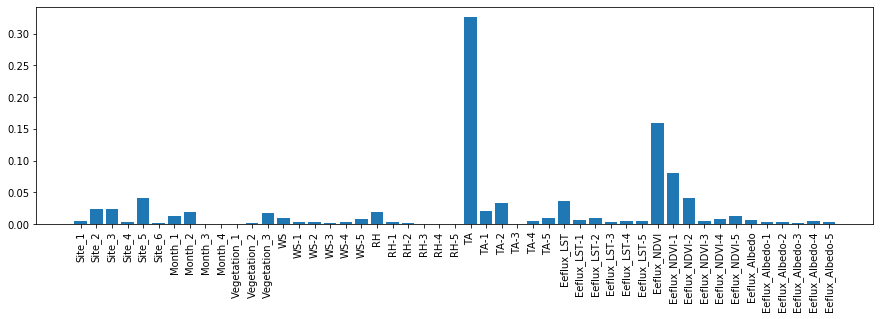

In [29]:
model = GradientBoostingRegressor(n_estimators=35, random_state= 10, min_samples_split=90, min_samples_leaf=60, max_features=0.5, max_depth=4, learning_rate=0.1, subsample= 0.6)
# fit the model
model.fit(X_train, Y_train)
columns  = X_train.columns
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance.flatten()):
    print('Feature: %s, Score: %.5f' % (columns[i],v))

# plot feature importance
pyplot.figure(figsize=(15,4))
pyplot.bar([x for x in columns], importance.flatten())
pyplot.xticks(rotation=90)
pyplot.show()

## Permutation Feature Importance

Permutation feature importance is a technique for calculating relative importance scores that
is independent of the model used. First, a model is fit on the dataset, such as a model that
does not support native feature importance scores. Then the model is used to make predictions
on a dataset, although the values of a feature (column) in the dataset are scrambled. This is
repeated for each feature in the dataset. Then this whole process is repeated 3, 5, 10 or more
times. The result is a mean importance score for each input feature (and distribution of scores
given the repeats)

In [35]:
# define the model
model = KNeighborsRegressor()
# fit the model
model.fit(X_train, Y_train)
# perform permutation importance
results = permutation_importance(model, X_train, Y_train , scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (columns[i],v))

Feature: Site_1, Score: 0.00138
Feature: Site_2, Score: -0.00710
Feature: Site_3, Score: 0.00144
Feature: Site_4, Score: -0.00473
Feature: Site_5, Score: 0.00625
Feature: Site_6, Score: -0.00046
Feature: Month_1, Score: 0.00114
Feature: Month_2, Score: 0.00233
Feature: Month_3, Score: -0.00228
Feature: Month_4, Score: -0.00160
Feature: Vegetation_1, Score: 0.00001
Feature: Vegetation_2, Score: 0.00231
Feature: Vegetation_3, Score: 0.00050
Feature: WS, Score: -0.00454
Feature: WS-1, Score: -0.00384
Feature: WS-2, Score: 0.00417
Feature: WS-3, Score: -0.00034
Feature: WS-4, Score: -0.00326
Feature: WS-5, Score: 0.00309
Feature: RH, Score: 0.62167
Feature: RH-1, Score: 0.43428
Feature: RH-2, Score: 0.41055
Feature: RH-3, Score: 0.40676
Feature: RH-4, Score: 0.31852
Feature: RH-5, Score: 0.43821
Feature: TA, Score: 0.34646
Feature: TA-1, Score: 0.16654
Feature: TA-2, Score: 0.14612
Feature: TA-3, Score: 0.10717
Feature: TA-4, Score: 0.10152
Feature: TA-5, Score: 0.09987
Feature: Eeflux_LST

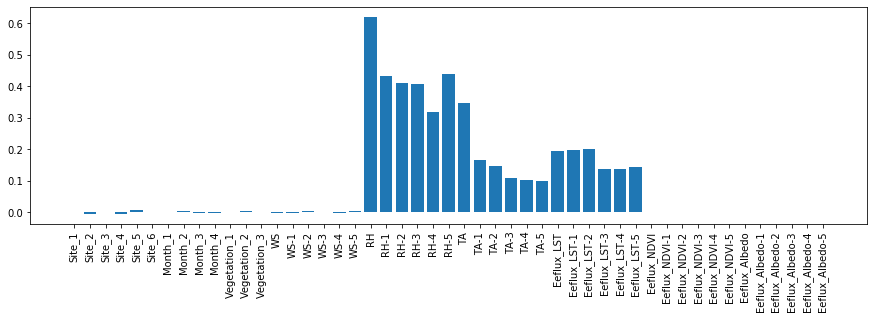

In [39]:
# plot feature importance
pyplot.figure(figsize=(15,4))
pyplot.bar([x for x in columns], importance)
pyplot.xticks(rotation=90)
pyplot.show()